<a href="https://colab.research.google.com/github/matari18/beltel_test/blob/main/test_beltel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Описание задачи

Построить модель прогнозирования продаж, которая учитывает день недели и акцию. Прогноз должен быть построен на январь 2024 года по всем товарам, которые участвовали в продажах в декабре 2023. Разделитель в файле ';'.

*sales_raw.csv* - данные о продажах


*   date - Дата продажи
*   item_id - Код товара
*   qnty - Количество продаж за день


*discounts_raw.csv* - данные об акциях
*   item_id - Код товара
*   promo_type_code - Код типа акции
*   sale_price_before_promo - Цена до акции
*   sale_price_time_promo - Цена на акцию
*   date_start - Дата начала акции
*   date_end - Дата окончания акции


*predictions.csv* - прогноз
*   date - Дата прогноза
*   item_id - Код товара
*   prediction - Количество товара (дробное число)

Метрика оценки качества прогноза - RMSE.

# План работы

>[Описание задачи](#scrollTo=XYWUXDijlvcy)

>[План работы](#scrollTo=PU7jRLrZsK1G)

>[Подключение библиотек и загрузка данных](#scrollTo=fk0E_gW3lCoe)

>[Обзор данных](#scrollTo=O6V_St-xF_WX)

>[Предобработка](#scrollTo=BK_r8tysGYi1)

>>[sales](#scrollTo=GuQLBefNdXuQ)

>>[discounts](#scrollTo=G2_p1YsIcsig)

>[Подготовка датафрейма](#scrollTo=UGB0FC3TfbSu)

>[Подбор наилучшей модели](#scrollTo=8MhwNpFZ1fzX)

>>[Разбиение датасета](#scrollTo=bTdNAgIp5rO_)

>>[Перебор моделей](#scrollTo=XyS15znl56hk)

>>[Попытка тюнинга модели](#scrollTo=fr7oVaoM5m-5)

>[Подготовка данных для итоговой выборки](#scrollTo=m8B4GQebK47o)

>[Предсказание итоговых значений и вывод результата](#scrollTo=AsKGC6wa5_f8)



#Подключение библиотек и загрузка данных


In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import dates

In [2]:
sales = pd.read_csv(
    "https://raw.githubusercontent.com/matari18/beltel_test/main/sales_raw.csv")

In [3]:
discounts = pd.read_csv(
    "https://raw.githubusercontent.com/matari18/beltel_test/main/discounts_raw.csv")

#Обзор данных


In [4]:
sales.head()

,date,item_id,qnty
0,2017-01-01,100001,7.0
1,2017-01-01,100003,2.0
2,2017-01-01,100006,13.0
3,2017-01-01,100010,5.0
4,2017-01-01,100035,53.0


In [5]:
sales.shape

(147143, 3)

Построим график суммарных продаж за весь период.

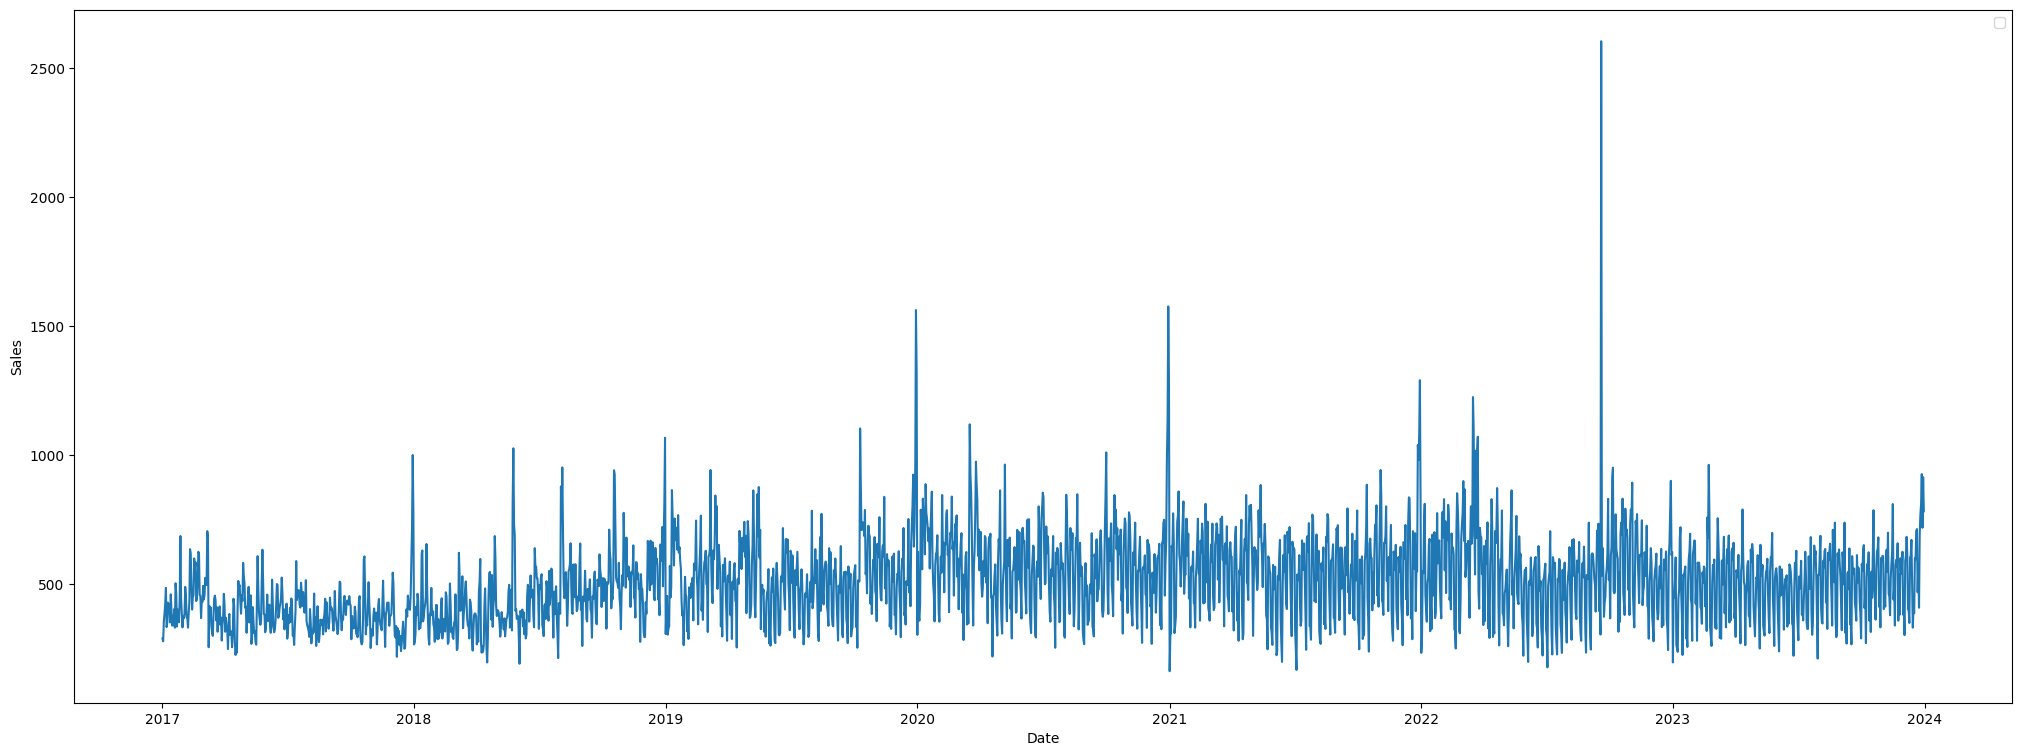

In [6]:
sum_sales = sales.groupby('date').sum().reset_index()
sum_sales['date'] = pd.to_datetime(sum_sales['date'])

plt.figure(figsize=(25, 9))
plt.xlabel('Date')
plt.ylabel('Sales')
plt.plot(sum_sales['date'], sum_sales['qnty'])
plt.legend()
plt.show()

In [7]:
discounts.head()

,item_id,promo_typeCode,sale_price_before_promo,sale_price_time_promo,date_start,date_end
0,100551,5.0,159.9,139.9,2023-03-02,2023-03-15
1,100553,5.0,159.9,139.9,2023-03-02,2023-03-15
2,100554,5.0,159.9,139.9,2023-03-02,2023-03-15
3,100558,5.0,159.9,139.9,2023-03-02,2023-03-15
4,100530,2.0,36.9,24.6,2021-09-09,2021-09-22


In [8]:
discounts.shape

(2081, 6)


#Предобработка

## sales

In [9]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147143 entries, 0 to 147142
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   date     147143 non-null  object 
 1   item_id  147143 non-null  int64  
 2   qnty     147143 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 3.4+ MB


In [10]:
sales.describe()

,item_id,qnty
count,147143.000000,147143.000000
mean,99552.401038,8.778191
std,8819.498659,27.696091
min,11200.000000,-3.000000
25%,100257.000000,1.000000
50%,100486.000000,3.000000
75%,100601.000000,7.000000
max,100691.000000,1201.000000


Переведем *date* в формат datetime

In [11]:
sales['date'] = pd.to_datetime(sales['date'], format='%Y-%m-%d')

Проверим пропуски.

In [12]:
sales.isna().sum()

date       0
item_id    0
qnty       0
dtype: int64

Проверим наличие дубликатов.

In [13]:
sales[sales.duplicated()].count()

date       0
item_id    0
qnty       0
dtype: int64

## discounts

In [14]:
discounts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2081 entries, 0 to 2080
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   item_id                  2081 non-null   int64  
 1   promo_typeCode           2041 non-null   float64
 2   sale_price_before_promo  2081 non-null   float64
 3   sale_price_time_promo    2081 non-null   float64
 4   date_start               2081 non-null   object 
 5   date_end                 2081 non-null   object 
dtypes: float64(3), int64(1), object(2)
memory usage: 97.7+ KB


Переведем *date_start* и *date_end* в формат datetime.

In [15]:
discounts['date_start'] = pd.to_datetime(discounts['date_start'], format='%Y-%m-%d')
discounts['date_end'] = pd.to_datetime(discounts['date_end'], format='%Y-%m-%d')

Проверим пропуски.

In [16]:
discounts.isna().sum()

item_id                     0
promo_typeCode             40
sale_price_before_promo     0
sale_price_time_promo       0
date_start                  0
date_end                    0
dtype: int64

In [17]:
round(discounts.isna().sum() * 100 / len(discounts), 2)

item_id                    0.00
promo_typeCode             1.92
sale_price_before_promo    0.00
sale_price_time_promo      0.00
date_start                 0.00
date_end                   0.00
dtype: float64

Их всего 1.92 %, поэтому можем удалить эти строки.

In [18]:
discounts = discounts.dropna()
discounts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2041 entries, 0 to 2080
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   item_id                  2041 non-null   int64         
 1   promo_typeCode           2041 non-null   float64       
 2   sale_price_before_promo  2041 non-null   float64       
 3   sale_price_time_promo    2041 non-null   float64       
 4   date_start               2041 non-null   datetime64[ns]
 5   date_end                 2041 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(3), int64(1)
memory usage: 111.6 KB


Проверим наличие дубликатов.

In [19]:
discounts[discounts.duplicated()].count()

item_id                    0
promo_typeCode             0
sale_price_before_promo    0
sale_price_time_promo      0
date_start                 0
date_end                   0
dtype: int64

# Подготовка датафрейма

Отберем товары из sales, которые участвовали в продажах в декабре 2023.

In [20]:
date_start = pd.to_datetime('2023-12-01', format='%Y-%m-%d')
date_end = pd.to_datetime('2023-12-31', format='%Y-%m-%d')
ITEMS_IDS = sales[(sales['date'] >= date_start)
                  & (sales['date'] <= date_end)]['item_id'].unique()
ITEMS_IDS

array([100545, 100645, 100683, 100612, 100165, 100611, 100006, 100601,
       100126, 100657, 100035, 100523, 100656, 100604, 100602, 100050,
       100646, 100663, 100558, 100553, 100517, 100448, 100390, 100644,
       100607, 100516, 100486, 100188, 100591, 100556, 100650, 100510,
       100010, 100259, 100192, 100182, 100454, 100193, 100455, 100346,
       100525, 100638, 100544, 100651, 100524, 100551, 100003, 100613,
       100245, 100590, 100354, 100614, 100450,  11200, 100348, 100528,
       100139, 100227, 100257, 100140, 100045, 100469, 100691, 100470,
       100639, 100648, 100621, 100001, 100176, 100228, 100530, 100471,
       100417, 100668, 100596, 100686, 100399, 100554, 100664, 100418,
       100394, 100665, 100487, 100473, 100370, 100547, 100181, 100184,
       100526, 100462, 100453, 100225, 100474, 100386, 100375, 100046,
       100662])

Создадим функцию для подготовки данных, т.к. нам придется повторить эти манипуляции с данными для предсказания на январь 2024.

In [21]:
def shape_data(init_df):
    # Отфильтруем по товарам и присоединим информацию по акциям.
    shaped_df = init_df[init_df['item_id'].isin(ITEMS_IDS)].merge(
        discounts, how='left', on='item_id').reset_index(drop=True)

    # Оставляем только те объекты, в которых дата покупки находится в рамках дат акции. Либо объекты без акции
    shaped_df = shaped_df[((shaped_df['date'] >= shaped_df['date_start'])
        & (shaped_df['date'] <= shaped_df['date_end']))
        | shaped_df['promo_typeCode'].isna()].reset_index(drop=True)

    # Заполним 0 пропуски в promo_typeCode.
    shaped_df['promo_typeCode'] = shaped_df['promo_typeCode'].fillna(0)

    # Добавим столбец, отражающий процент цены по акции по отношению к цене до акции. Для товаров без акций заполним 100.
    shaped_df['promo_discount'] = round(
        100 * shaped_df['sale_price_time_promo']/shaped_df['sale_price_before_promo'], 2)
    shaped_df['promo_discount'] = shaped_df['promo_discount'].fillna(100.)

    # Удалим столбцы sale_price_before_promo, sale_price_time_promo, date_start и date_end.
    shaped_df = shaped_df.drop(['sale_price_before_promo', 'sale_price_time_promo',
                  'date_start', 'date_end'], axis=1)

    # Добавим столбец day_of_week.
    shaped_df['day_of_week']= pd.to_datetime(shaped_df['date']).dt.dayofweek
    return shaped_df

Подготавливаем датафрейм.

In [22]:
df = shape_data(sales)
df.head()

,date,item_id,qnty,promo_typeCode,promo_discount,day_of_week
0,2017-01-01,100001,7.0,0.0,100.0,6
1,2017-01-01,100003,2.0,0.0,100.0,6
2,2017-01-01,100006,13.0,0.0,100.0,6
3,2017-01-01,100010,5.0,0.0,100.0,6
4,2017-01-01,100035,53.0,0.0,100.0,6


In [23]:
df.sample(10)

,date,item_id,qnty,promo_typeCode,promo_discount,day_of_week
14670,2020-05-06,100001,2.0,0.0,100.00,2
3539,2017-12-04,100010,5.0,0.0,100.00,0
38413,2023-03-08,100473,6.0,10.0,74.97,2
6217,2018-08-11,100591,8.0,0.0,100.00,5
7737,2018-12-27,100510,7.0,0.0,100.00,3
14740,2020-05-08,100375,1.0,5.0,71.41,4
6451,2018-09-01,100182,1.0,0.0,100.00,5
37006,2023-01-04,100227,5.0,6.0,82.13,2
28438,2021-12-03,100354,5.0,5.0,51.50,4
33643,2022-08-06,100528,10.0,5.0,84.60,5


# Подбор наилучшей модели

## Разбиение датасета

Разобьем выборку на тренировочную и тестовую.
Сделаем предсказание для декабря 2023 по всем предыдущим данным.

In [24]:
train = df[(df['date'] < '2023-12-01') ]
test = df[df['date'] >= '2023-12-01']

X_train = df[df.index.isin(train.index)].drop(['date', 'qnty'], axis=1)
X_test = df[df.index.isin(test.index)].drop(['date', 'qnty'], axis=1)

y_train = df[df.index.isin(train.index)]['qnty']
y_test = df[df.index.isin(test.index)]['qnty']

## Перебор моделей

Для нашей задачи рассмотрим LinearRegression, DecisionTreeRegressor, RandomForestRegressor, XGBRegressor.

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

RS = 42

lin_reg = LinearRegression()
des_tree_reg = DecisionTreeRegressor(random_state=RS)
rand_for_reg = RandomForestRegressor(random_state=RS)
xgb_reg = xgb.XGBRegressor(random_state=RS)

models = {'lin_reg': lin_reg,
          'des_tree_reg': des_tree_reg,
          'rand_for_reg': rand_for_reg,
          'xgb_reg': xgb_reg}

Метрика качества - RMSE.

In [26]:
from sklearn.metrics import mean_squared_error

def metrics(predicted):
    return round(mean_squared_error(y_test, predicted, squared=False), 3)

Создадим функцию для проверки моделей и построения графиков.

In [27]:
def eval(model_name):
    model = models[model_name]
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)

    plt.figure(figsize=(15, 9))
    plt.scatter(range(len(y_test)), y_test, color='b', label="Actual values")
    plt.scatter(range(len(prediction)), prediction, color='r', label="Predicted values")
    plt.ylabel('qnty')
    plt.legend()
    plt.show()

    print('Model:', model_name)
    print('RMSE: ', metrics(prediction), '\n')

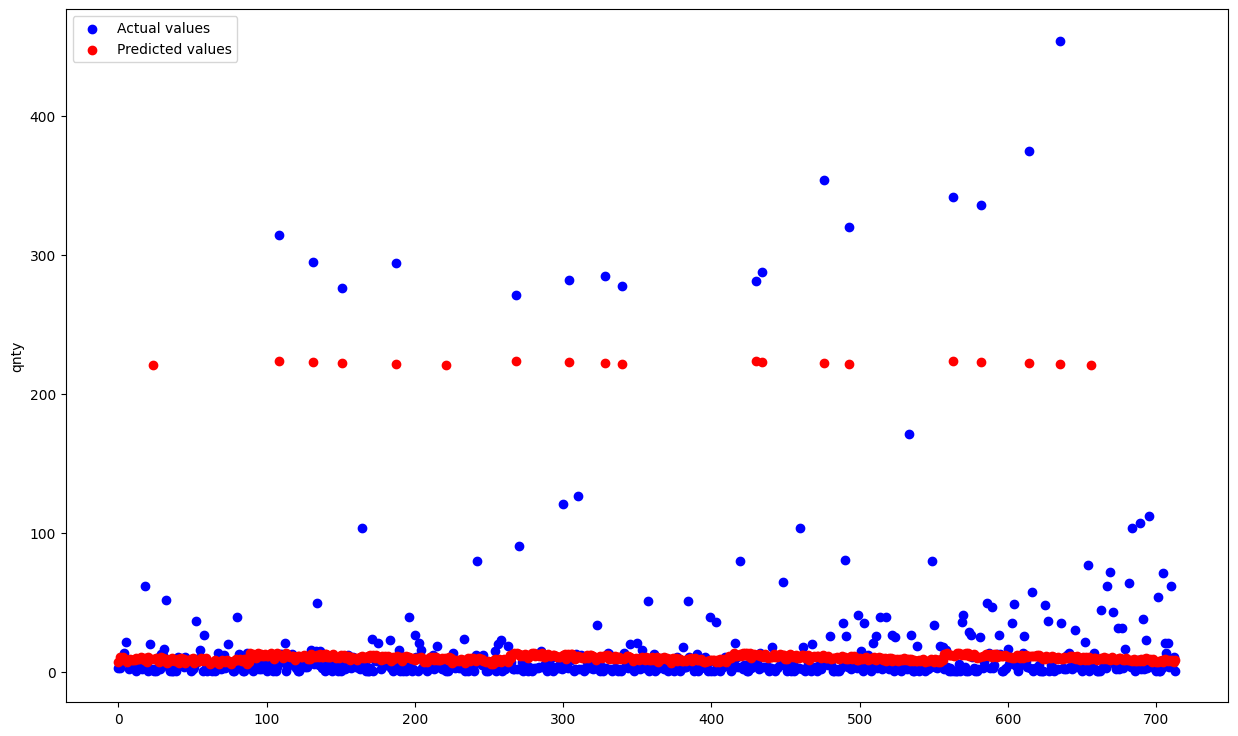

Model: lin_reg
RMSE:  27.424 



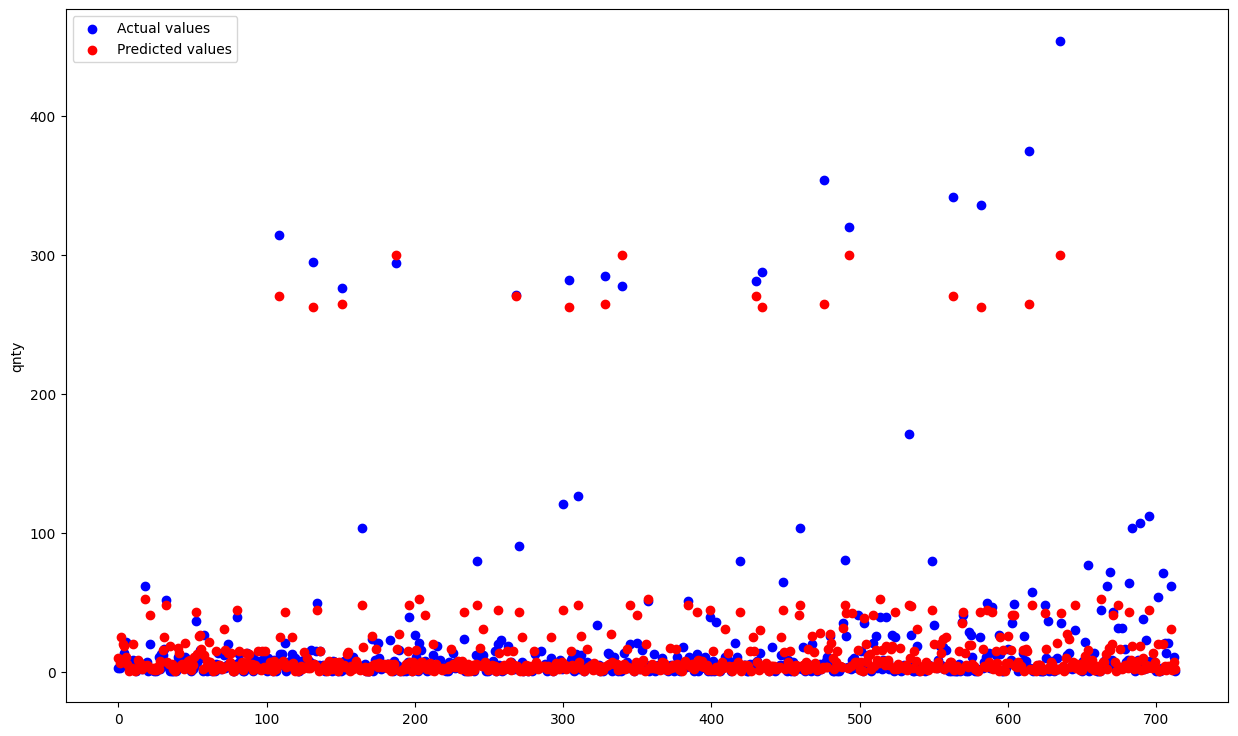

Model: des_tree_reg
RMSE:  15.818 



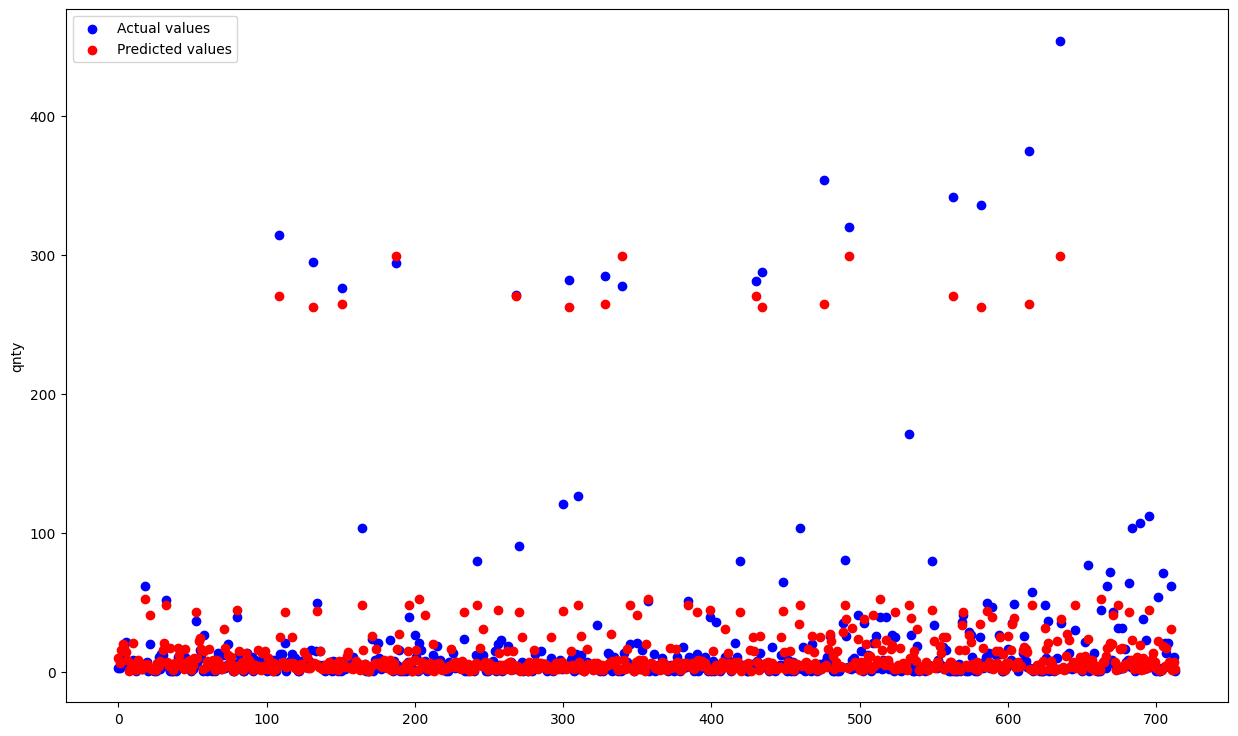

Model: rand_for_reg
RMSE:  15.328 



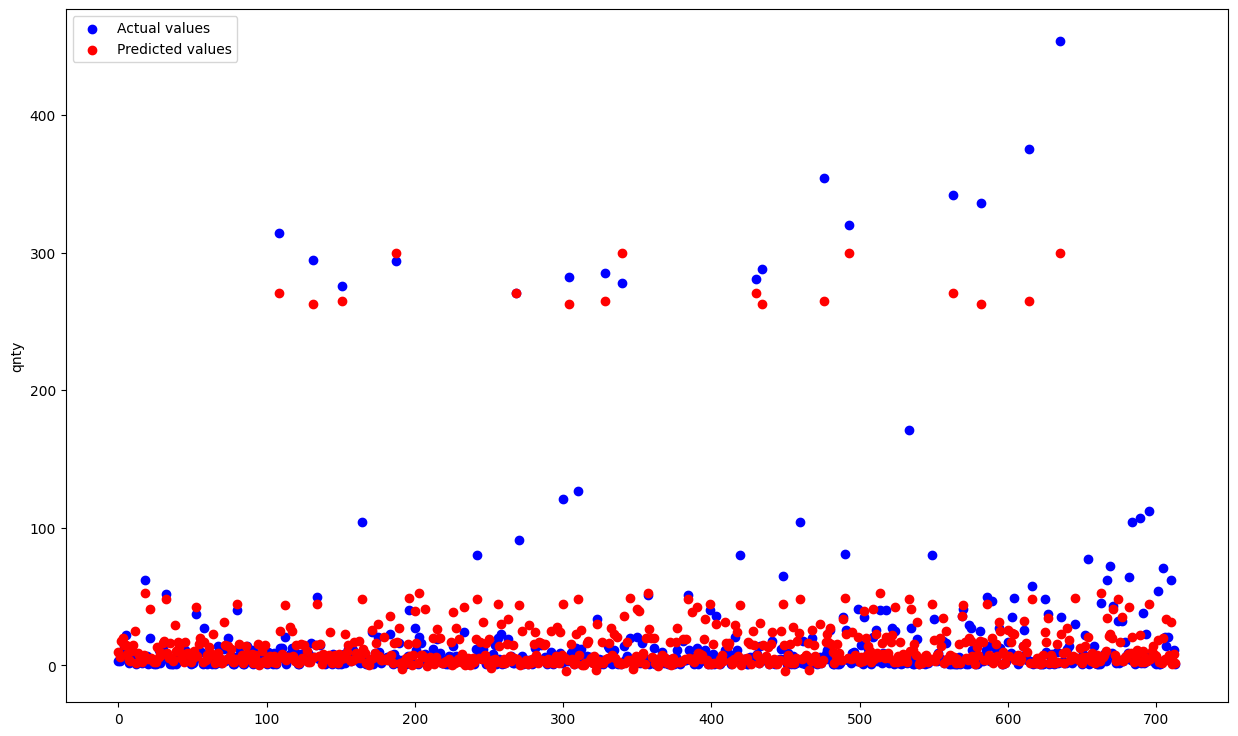

Model: xgb_reg
RMSE:  15.842 



In [28]:
for key, value in models.items():
    eval(key)

Видим, что лучшая модель - RandomForestRegressor с величиной RMSE = 15.328.




## Попытка тюнинга модели

Используем GridSearchCV для подбора оптимальных параметров.

In [29]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'n_estimators': list(range(100, 350, 50)),
    'max_depth': list(range(1, 5)),
}

grid_search = GridSearchCV(RandomForestRegressor(),
                           param_grid=parameters)
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'max_depth': 4, 'n_estimators': 300}

In [30]:
tuned_rand_for = RandomForestRegressor(**grid_search.best_params_, random_state=RS)

tuned_rand_for.fit(X_train, y_train)
prediction = tuned_rand_for.predict(X_test)
metrics(prediction)

17.581

Получили значение метрики 17.581. Это хуже, чем у модели с дефолтными значениями, значит, останавливаем свой выбор на дефолтной.

# Подготовка данных для итоговой выборки

Создаем основу датафрейма.  

In [31]:
columns = ['date', 'item_id']
dates = pd.date_range(start='2024-01-01', end='2024-01-31')
data = [(d, i) for d in dates for i in ITEMS_IDS]

X_jan = pd.DataFrame(data=data, columns=columns)
X_jan.head()

,date,item_id
0,2024-01-01,100545
1,2024-01-01,100645
2,2024-01-01,100683
3,2024-01-01,100612
4,2024-01-01,100165


Произведем подготовку данных.

In [32]:
X_jan = shape_data(X_jan)
X_jan.head()

,date,item_id,promo_typeCode,promo_discount,day_of_week
0,2024-01-01,100645,5.0,64.49,0
1,2024-01-01,100165,5.0,85.92,0
2,2024-01-01,100006,0.0,100.00,0
3,2024-01-01,100126,44.0,93.33,0
4,2024-01-01,100035,0.0,100.00,0


# Предсказание итоговых значений и вывод результата

Обучим нашу модель на всей выборке и предскажем на данных X_jan.

In [33]:
X_train = df.drop(['date', 'qnty'], axis=1)
y_train = df['qnty']

rand_for_reg = RandomForestRegressor(random_state=RS)
rand_for_reg.fit(X_train, y_train)

prediction = rand_for_reg.predict(X_jan.drop(['date'], axis=1))

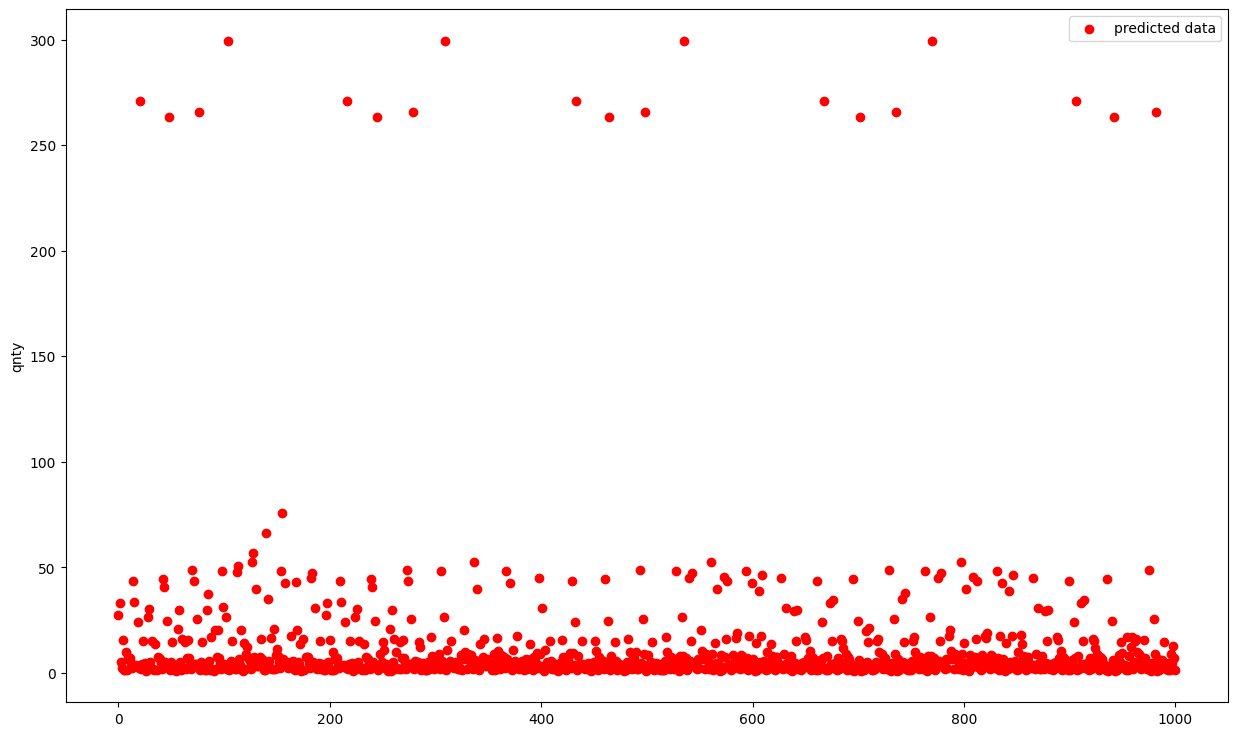

In [34]:
plt.figure(figsize=(15, 9))

plt.scatter(range(len(prediction)), prediction, color='r', label="predicted data")
plt.ylabel('qnty')
plt.legend()
plt.show()

Выведем график суммарных продаж вместе с предсказанными значениями.

In [35]:
X_jan['prediction'] = prediction

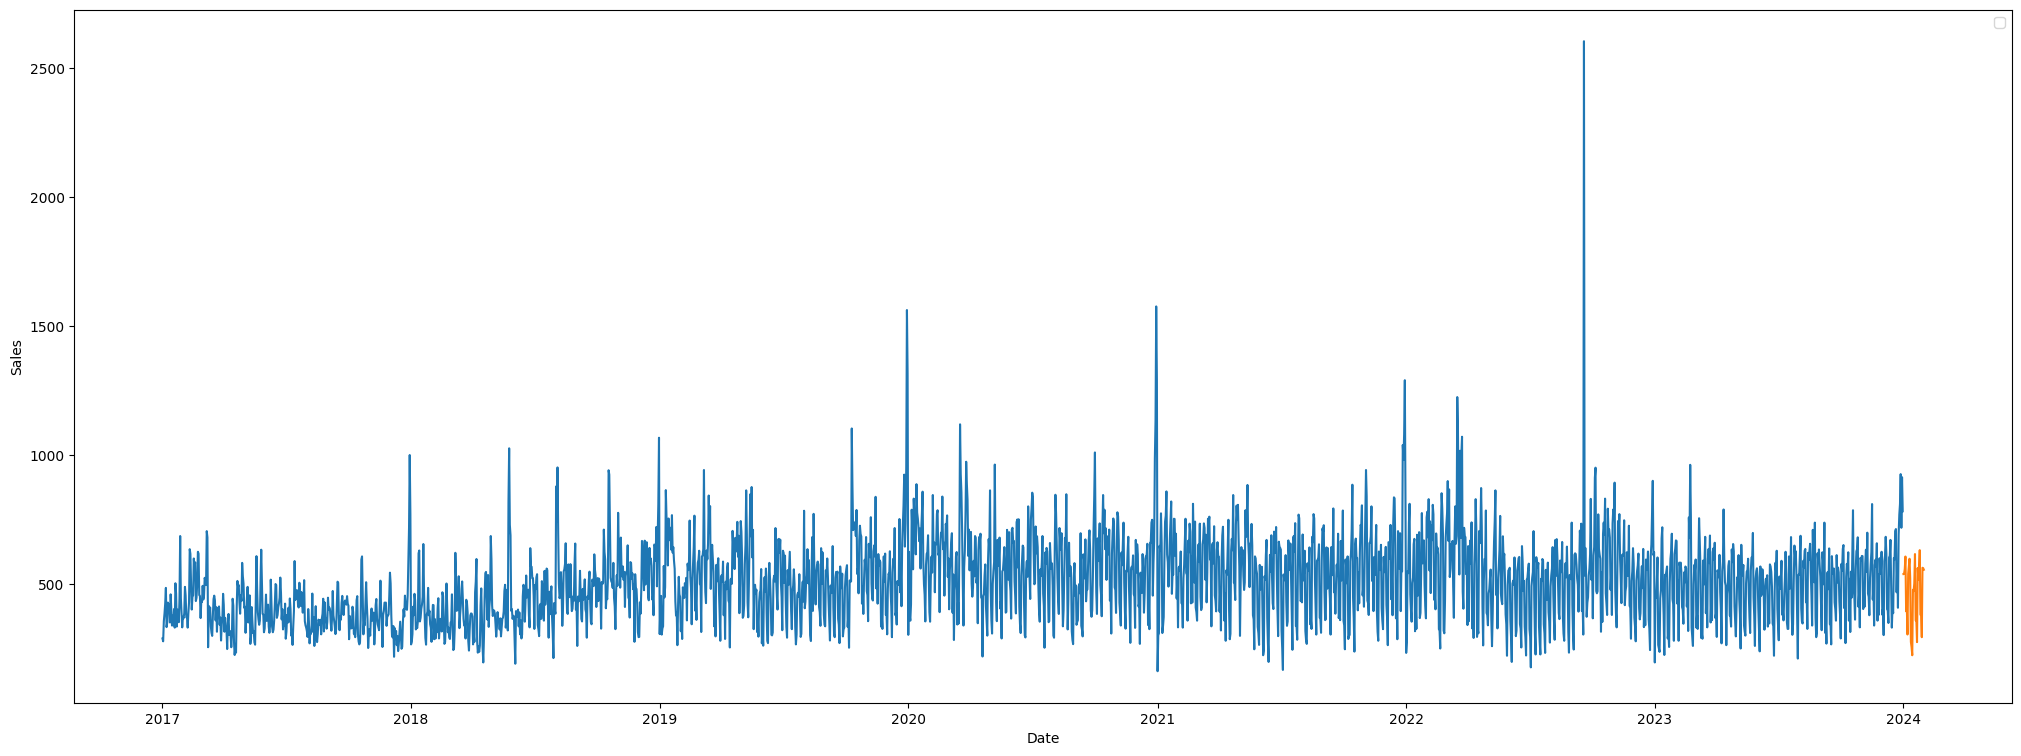

In [36]:
sum_sales_jan_2024 = X_jan.groupby('date').sum().reset_index()
sum_sales['date'] = pd.to_datetime(sum_sales['date'])

plt.figure(figsize=(25, 9))
plt.xlabel('Date')
plt.ylabel('Sales')
plt.plot(sum_sales['date'], sum_sales['qnty'])
plt.plot(sum_sales_jan_2024['date'], sum_sales_jan_2024['prediction'])
plt.legend()
plt.show()

Сравним суммарные продажи в январе 2023 и январе 2024.

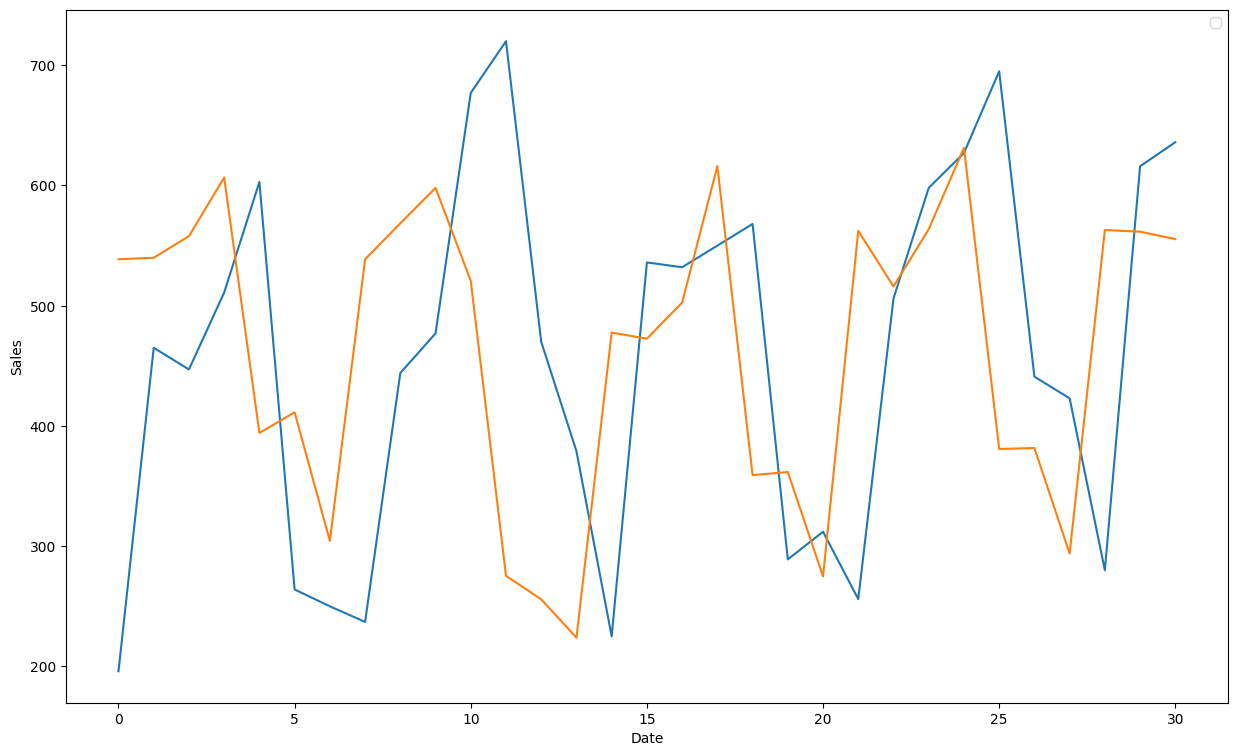

In [37]:
sum_sales_jan2023 = sum_sales[(sum_sales['date'] <= '2023-01-31') & (sum_sales['date'] >= '2023-01-01')]

plt.figure(figsize=(15, 9))
plt.xlabel('Date')
plt.ylabel('Sales')
plt.plot(range(len(sum_sales_jan2023)), sum_sales_jan2023['qnty'])
plt.plot(range(len(sum_sales_jan_2024)), sum_sales_jan_2024['prediction'])
plt.legend()
plt.show()

Сохраним результат.

In [38]:
res = X_jan[['date', 'item_id', 'prediction']]
res.to_csv('predictions.csv', sep=';', index=False)
res.head(10)

,date,item_id,prediction
0,2024-01-01,100645,27.483333
1,2024-01-01,100165,33.289404
2,2024-01-01,100006,5.350933
3,2024-01-01,100126,2.284929
4,2024-01-01,100035,15.517635
5,2024-01-01,100656,1.330654
6,2024-01-01,100390,1.534333
7,2024-01-01,100516,9.772738
8,2024-01-01,100188,1.386099
9,2024-01-01,100591,7.357962
